<a href="https://colab.research.google.com/github/nsn20/bert/blob/main/BERT_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install praw

In [ ]:
import tensorflow as tf
import pandas as pd
import praw
from transformers import TFAutoModelForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt 

In [ ]:
model = TFAutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing TFBertForTokenClassification: ['dropout_147']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english and are newly initialized: ['dropout_73']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
reddit = praw.Reddit(client_id = 'ovi9op7w_9iWOw',
                     client_secret = 'gy3r8s4J5gw8b6jlu3doZUZoc9f0GA',
                     user_agent = 'bert')
science = reddit.subreddit('science')

In [ ]:
label_list = ["O","B-MISC","I-MISC","B-PER","I-PER","B-ORG","I-ORG","B-LOC","I-LOC"]
categories = {'I-LOC': [], 'I-ORG': [], 'I-PER': [], 'B-LOC': [], 'B-ORG': [], 'B-PER': []}
temp = ''
current = ''
old_tag = ''

In [ ]:
def reply(top_comment, comment_list):
    if len(top_comment.replies) == 0:
        return
    else:
        for num, comment in enumerate(top_comment.replies):
            try:
                comment_list.append(str(comment.body))
            except:
                continue
            reply(comment, comment_list)

In [ ]:

top = science.top('year', limit=1)
comments = [] 
for submission in top:
    submission_comm = reddit.submission(id=submission.id)
    comments.append(str(submission.title))
    for count, top_comment in enumerate(submission_comm.comments):
        try:
            reply(top_comment, comments)
        except:
            continue
print(comments)
print(len(comments))

['The first human trial of a COVID-19 vaccine finds that it is safe, well-tolerated, and induces a rapid immune response: “These results represent an important milestone.”', 'Edit: Comment originally talked about why phase 1 trials were not blinded, when I meant controlled.\n\nThis is a phase 1 trial. The goal here is not to determine effectiveness, but to gauge the safety of various doses and determine what kind of immune response to expect at different doses in order to inform phase 2 and 3. That is why you don’t have a control group for this phase, you need data specifically about the human body’s response to the vaccine at various dosage levels. \n\nBased on this data they’ll likely pick a single dose that appears to cause the right immune response and then move into controlled trials with larger groups. The only way you could move faster would be challenge trials, intentionally infecting test subjects, but that is unethical.', 'Just to add one more thing, the blind studies will be

In [ ]:


for sequence in comments:
    if len(sequence) > 512:
        continue

    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
    inputs = tokenizer.encode(sequence, return_tensors="tf")
    outputs = model(inputs)[0]
    predictions = tf.argmax(outputs, axis=2)
    

    result = [(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].numpy())]
    for i in result:
        if i[1] in ['O', 'B-MISC', 'I-MISC']:
            if len(current) > 0:
                stripped_word = temp.strip()
                if len(stripped_word) > 1:
                    categories[current].append(stripped_word)
            temp = ''
            current = ''
            continue
        else:
            current = i[1]

            if old_tag != current and len(old_tag) > 0:
                stripped_word = temp.strip()
                if len(stripped_wordd) > 1:
                    categories[old_tag].append(stripped_word)
                temp = ''
                current = ''

            if i[0].startswith('##'): 
                temp += i[0][2:].upper()
            elif i[1] in ['I-PER', 'I-ORG', 'I-LOC', 'B-LOC', 'B-ORG', 'B-PER']:
                temp += " " + i[0].upper()
                current = i[1]
            old_tag = current



In [ ]:
words = list(categories['I-LOC'] + categories['B-LOC'] + categories['I-ORG'] + categories['B-ORG'] + categories['I-PER'] + categories['B-PER'])
print(words)
word_count = {}
for word in words:
  if word not in word_count:
    word_count[word] = 1
  else:
    word_count[word] += 1
print(word_count)
keyword = dict((k, v) for k, v in word_count.items() if v >= 2)

['ER', 'OXFORD', '', 'WEST', 'CHINA', '', 'UK', 'UK', 'OXFORD', 'UK', '', 'RUSSIA', 'US', '', 'CANADA', 'CANADA', '', 'AFRICA', '', 'AMERICA', 'INDIA', 'OXFORD', '', 'UK', '', 'US', '', 'OXFORD', 'US', '', 'UK', 'UK', 'OXFORD', 'INDIA', 'OXFORD', '', 'US', '', 'US', '', 'CANADA', '', 'CANADA', 'SAUDI ARABIA', '', 'OXFORD', 'EUROPE', 'US', '', 'US', 'US', '', 'CANSINO', 'CANSINO', 'ITE', 'FDA', 'FDA', '', 'LILLY', 'ELI LILLY', '', 'IMO', '', 'BARDA', 'HHS', '', 'CANSINO', '', 'GO', 'LE', 'CO', 'UK', '', 'MODERNA', 'LANCET', 'JAMA', 'NEJM', 'BMJ', 'THE LANCET', 'LANCET', 'NATURE', 'BMJ', 'NATURE', 'THE LANCET', 'NATURE MEDICINE', 'NATURE', 'NAT MED', 'LANCET', '', 'NEJM', 'JAMA', 'LANCET', 'LANCET', 'NEJM', 'JAMA', 'THE LANCET', '', 'LANCET', 'OP', 'OP', '', 'MERS', '', 'PLASE 2', '', 'REUTERS', 'MODERNA', 'ASTRA ZENECA', 'ASTRAZENECA', '', 'CANSINO', 'THE NATIONAL RESEARCH COUNCIL OF CANADA', '', 'GOVERNMENT', '', 'LANCET', 'MODERNA', '', '', 'BRITISH MEDICAL JOURNAL', 'NEW ENGLAND JOUR

Text(0.5, 1.0, 'Keywords part of the top post from the past year')

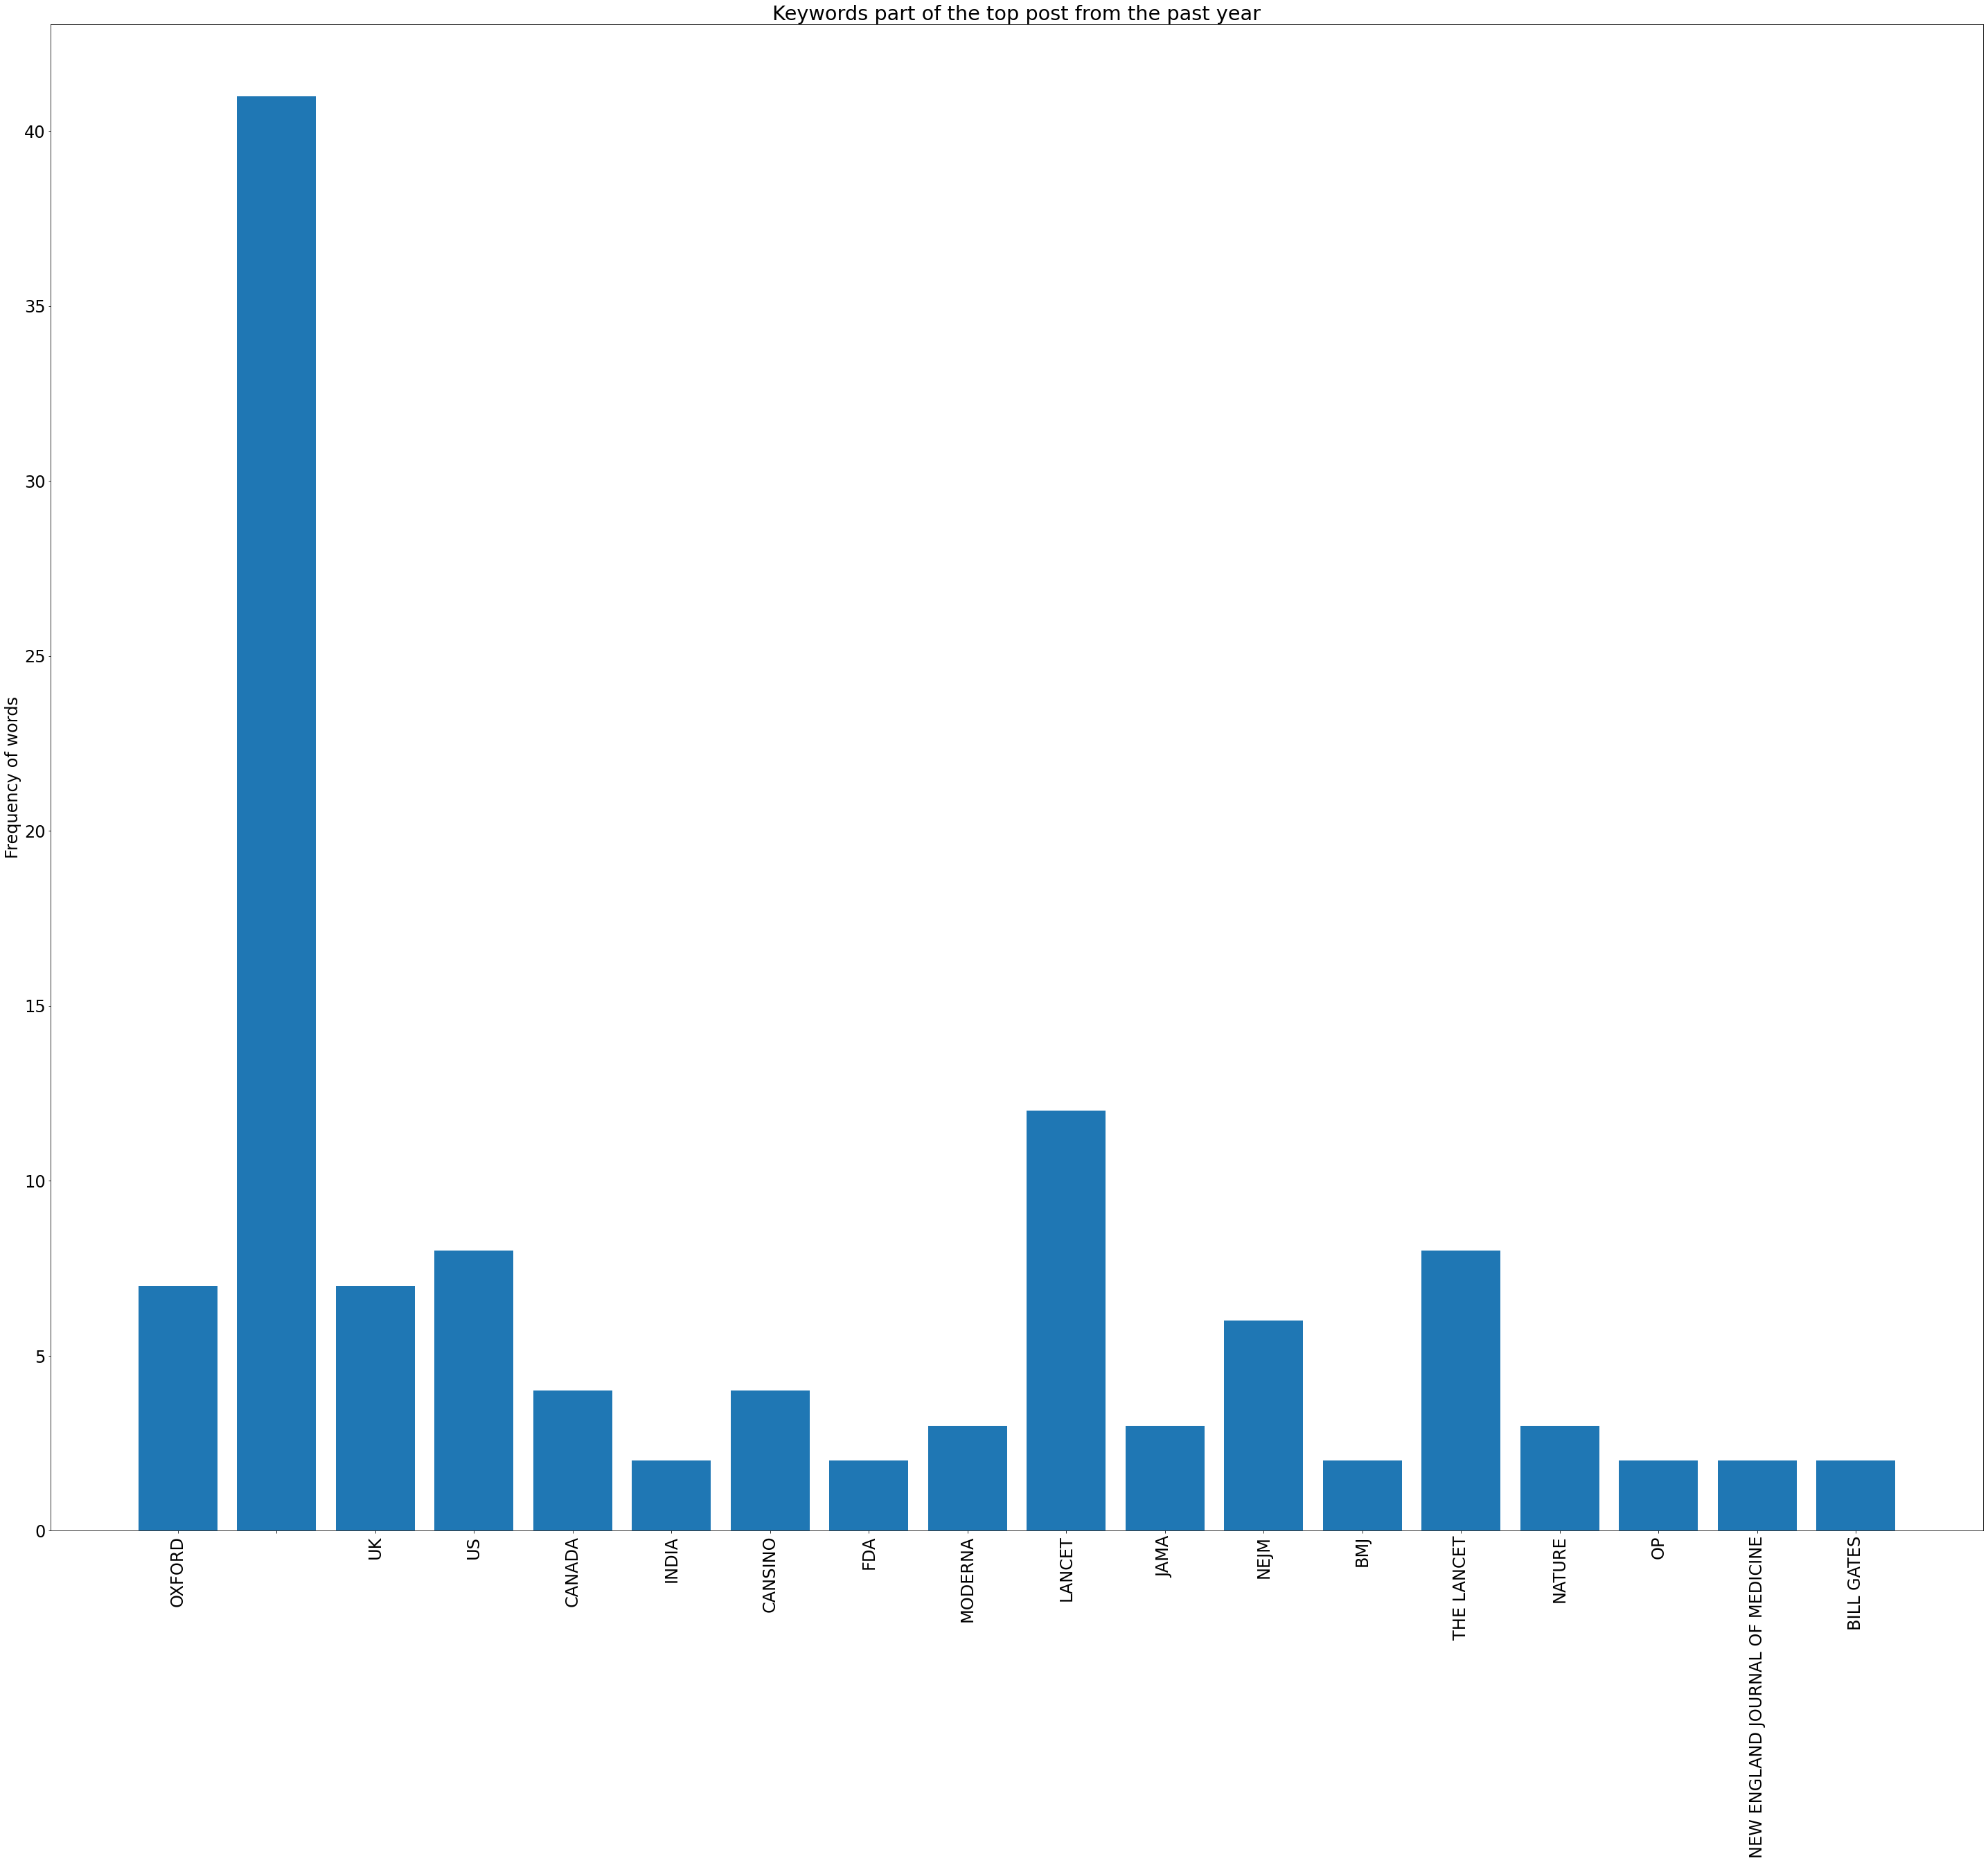

In [ ]:
height = 40
width = 50
plt.figure(figsize=(width, height))
plt.rcParams.update({'font.size': 24})

plt.bar(range(len(keyword)), list(keyword.values()))
plt.xticks(range(len(keyword)), list(keyword.keys()), rotation = 90)
plt.ylabel("Frequency of words")
plt.title("Keywords part of the top post from the past year")

{'BILL GATES': 2, '': 6, 'TRUMP': 1, 'BERNIE': 1, 'ANDREW WAKEFIELD': 1, 'GOD': 1, 'RICHARD HORTON': 1, 'JONAS': 1, 'SALK': 1}


Text(0.5, 1.0, 'Keywords part of the top post from the past year')

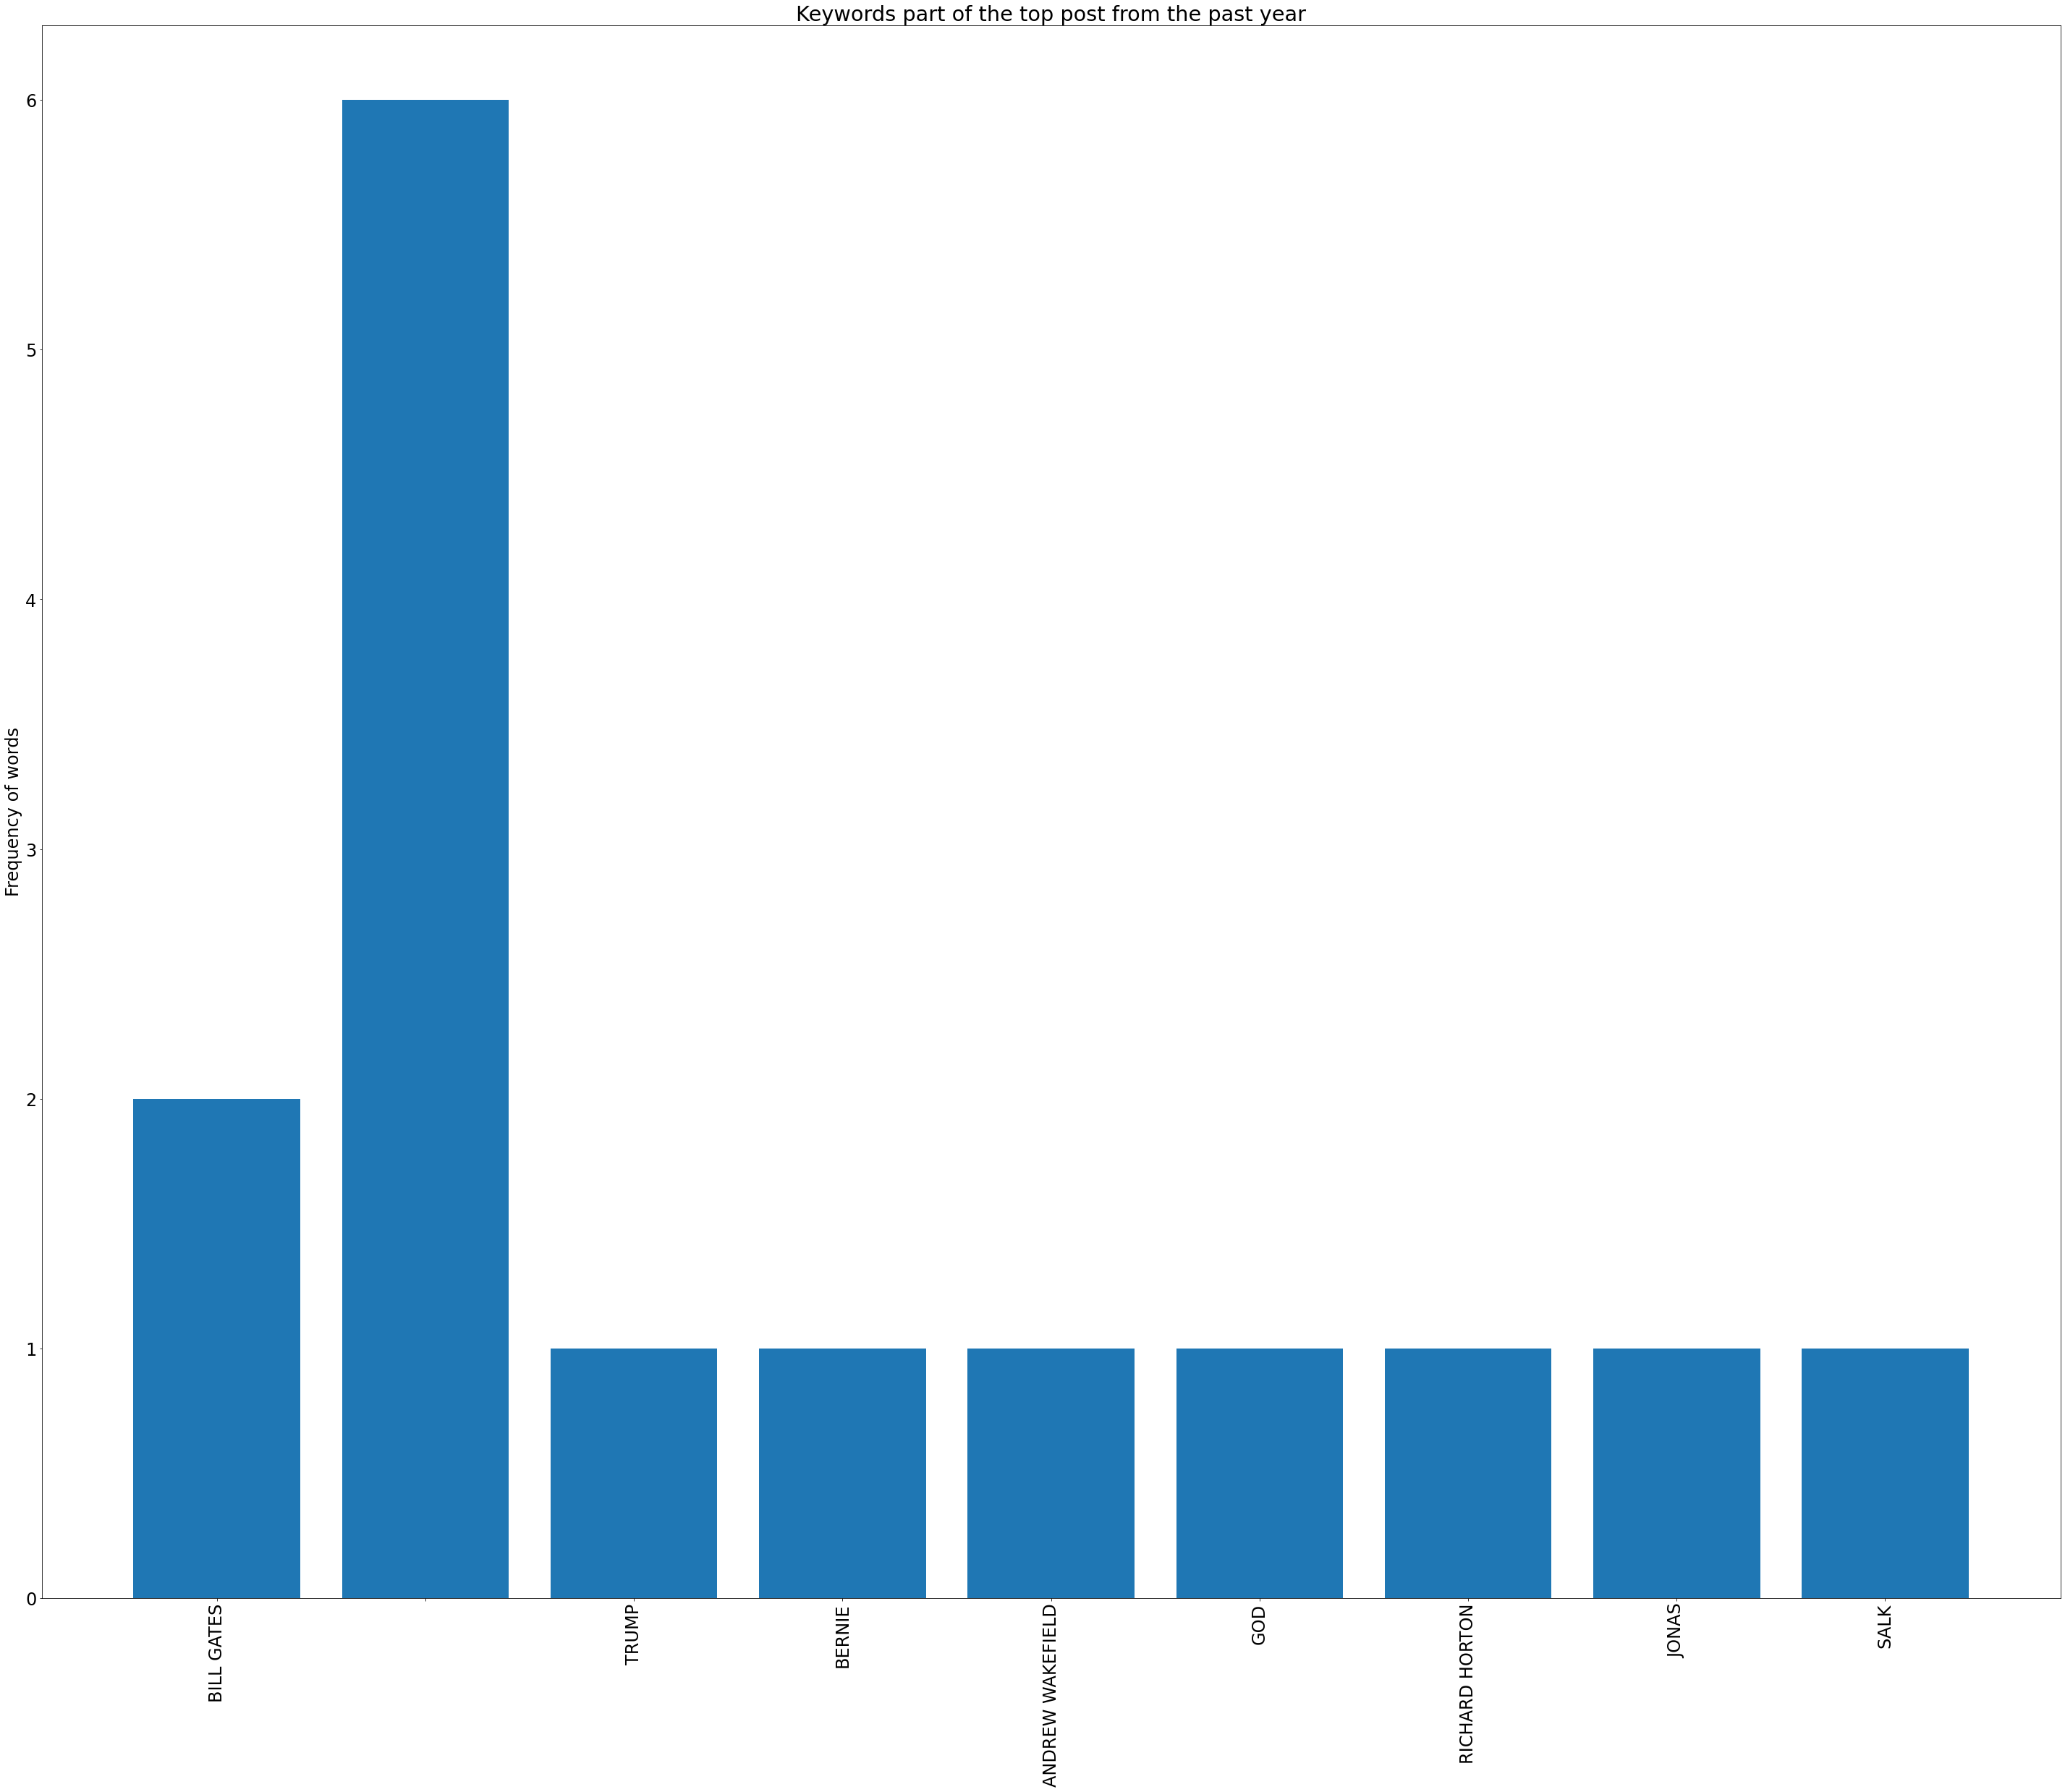

In [ ]:
names = list(categories['I-PER'] + categories['B-PER'])
word_count = {}
for name in names:
  if name not in word_count:
    word_count[name] = 1
  else:
    word_count[name] += 1

print(word_count)

height = 40
width = 50
plt.figure(figsize=(width, height))
plt.rcParams.update({'font.size': 24})

plt.bar(range(len(word_count)), list(word_count.values()))
plt.xticks(range(len(word_count)), list(word_count.keys()), rotation = 90)
plt.ylabel("Frequency of words")
plt.title("Names")